In [50]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import time
import gc

# Import Monte Carlo data

In [2]:
inputMC = '~/data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

In [3]:
tick = time.perf_counter()
df_MC_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tock = time.perf_counter()
print(f"Monte Carlo imported in {tock - tick:0.4f} seconds.")

Monte Carlo imported in 0.8915 seconds.


In [4]:
tick = time.perf_counter()
df_MC_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tock = time.perf_counter()
print(f"Monte Carlo Truth imported in {tock - tick:0.4f} seconds.")

Monte Carlo Truth imported in 16.3598 seconds.


In [5]:
tick = time.perf_counter()
df_MC = pd.merge(df_MC_truth, df_MC_reco.loc[df_MC_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')
tock = time.perf_counter()
print(f"Monte Carlo merged in {tock - tick:0.4f} seconds.")

Monte Carlo merged in 146.7959 seconds.


In [6]:
## Cut on true Lambda decay vertex. 8000 is the maximum to have events,
## no Lambda in the MC decays farther than that.
LambdaZVertexLowerBound = 5500
LambdaZVertexUpperBound = 8000
df_MC = df_MC[(df_MC['MCTRUTH_L_ENDVERTEX_Z'] > LambdaZVertexLowerBound) & (df_MC['MCTRUTH_L_ENDVERTEX_Z'] < LambdaZVertexUpperBound)]
df_MC

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_pim_PZ,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
29,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,25203.607422,171.069519,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375
68,0.6988,0.1457,8.921400,-275.270508,517.665710,6044.109863,-1734.800049,3088.909912,36901.781250,-165.570007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,0.1737,-0.2302,6.356200,-30.531700,-311.828491,7045.362305,-97.980003,-924.580017,18892.099609,5.040000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,0.5991,-0.2019,37.328098,-31.441000,-262.683105,7216.815430,-199.880005,-1420.540039,36778.171875,-6.320000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,0.9935,-0.9283,-16.168501,-34.232498,-338.234802,7619.163086,-252.279999,-2650.100098,61709.449219,-106.110001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921753,0.9233,0.1671,9.821300,65.648102,114.385803,6598.966797,795.969971,1589.550049,88814.687500,283.649994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921755,0.8836,0.1212,12.387000,185.393295,-125.622803,7188.478516,1751.500000,-1272.150024,71170.023438,553.190002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921777,1.2719,0.2954,1.781700,220.534607,180.934799,7350.403809,2247.919922,1818.459961,75455.960938,707.440002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
## Cleanup
del(df_MC_truth)
del(df_MC_reco)
gc.collect()

0

# Selection definitions

In [8]:
## Select reconstructed muons. There is a very small (~4500) number of reconstructed events
## where the 'PID_Reconstructed' variables do not match the corresponding 'PID_Reconstructible'.
reconstructibleMuons = (df_MC['mum_Reconstructible']=='ChargedLong') & (df_MC['mup_Reconstructible']=='ChargedLong')
reconstructedMuons = (df_MC['mum_Reconstructed']=='ChargedLong') & (df_MC['mup_Reconstructed']=='ChargedLong')

## The mismatched events here are a bit more (~11k). I suppose this could be because of particles
## potentially reconstructible as something "better" than TTRACKS (e.g. LONG) that get a degreaded result.
reconstructibleTTracks = (df_MC['pim_Reconstructible']=='ChargedTtrack') & (df_MC['p_Reconstructible']=='ChargedTtrack')
reconstructedTTracks = (df_MC['pim_Reconstructed']=='ChargedTtrack') & (df_MC['p_Reconstructed']=='ChargedTtrack')

## This selects all events actually reconstructed in the MC_reco. Since we have constrained reconstruction
## of muons, protons and pions, the deficit must be due to Lambda and/or Lambdab reconstrution failure.
## (Or J/psi, sure, but we assume that two LONG muons are tracked much better than two TTRACKS proton and pions.)
allReconstructedEvents = ((df_MC['Rec_key'] >= 0) & (df_MC['TrackType'] == 'T'))

In [9]:
selectionCandidates = (
    reconstructibleMuons & reconstructedMuons
    & reconstructibleTTracks & reconstructedTTracks
)
    
selectionPassed = selectionCandidates & allReconstructedEvents

In [22]:
df_MC_Reconstructed = df_MC[selectionPassed]
df_MC_Failed = df_MC[selectionCandidates & ~selectionPassed]

# Distribution comparison

In [30]:
df_MC['Lb_PX']

MC_key
29           -37.265965
68                  NaN
79                  NaN
89                  NaN
102                 NaN
               ...     
8921753             NaN
8921755             NaN
8921777             NaN
8921803             NaN
8921805    11536.079102
Name: Lb_PX, Length: 467699, dtype: float32

In [27]:
list(df_MC_Failed)

['MCTRUTH_Lb_ENDVERTEX_X',
 'MCTRUTH_Lb_ENDVERTEX_Y',
 'MCTRUTH_Lb_ENDVERTEX_Z',
 'MCTRUTH_L_ENDVERTEX_X',
 'MCTRUTH_L_ENDVERTEX_Y',
 'MCTRUTH_L_ENDVERTEX_Z',
 'MCTRUTH_p_PX',
 'MCTRUTH_p_PY',
 'MCTRUTH_p_PZ',
 'MCTRUTH_pim_PX',
 'MCTRUTH_pim_PY',
 'MCTRUTH_pim_PZ',
 'MCTRUTH_mum_PX',
 'MCTRUTH_mum_PY',
 'MCTRUTH_mum_PZ',
 'MCTRUTH_mup_PX',
 'MCTRUTH_mup_PY',
 'MCTRUTH_mup_PZ',
 'MCTRUTH_Lb_ID',
 'MCTRUTH_L_ID',
 'Lb_Reconstructible',
 'Lb_Reconstructed',
 'L_Reconstructible',
 'L_Reconstructed',
 'Jpsi_Reconstructible',
 'Jpsi_Reconstructed',
 'p_Reconstructible',
 'p_Reconstructed',
 'pim_Reconstructible',
 'pim_Reconstructed',
 'mum_Reconstructible',
 'mum_Reconstructed',
 'mup_Reconstructible',
 'mup_Reconstructed',
 'p_PP_X',
 'p_PP_Y',
 'p_PP_Z',
 'p_PP_PX',
 'p_PP_PY',
 'p_PP_PZ',
 'p_PP_Weight',
 'pim_PP_X',
 'pim_PP_Y',
 'pim_PP_Z',
 'pim_PP_PX',
 'pim_PP_PY',
 'pim_PP_PZ',
 'pim_PP_Weight',
 'mum_PP_X',
 'mum_PP_Y',
 'mum_PP_Z',
 'mum_PP_PX',
 'mum_PP_PY',
 'mum_PP_PZ',
 'mum

## $\Lambda_b$ decay vertices

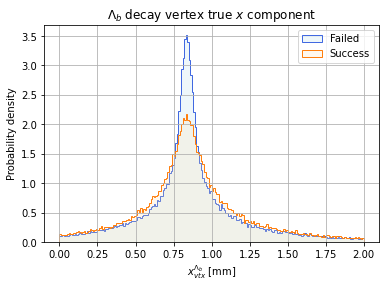

In [132]:
featureToPlot = 'MCTRUTH_Lb_ENDVERTEX_X'
featureLabel = '$x^{\Lambda_b}_{vtx}$ [mm]'
featureTitle = '$\Lambda_b$ decay vertex true $x$ component'
binNumber = 200
boundaries = (0,2)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

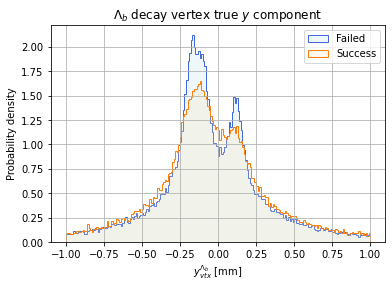

In [131]:
featureToPlot = 'MCTRUTH_Lb_ENDVERTEX_Y'
featureLabel = '$y^{\Lambda_b}_{vtx}$ [mm]'
featureTitle = '$\Lambda_b$ decay vertex true $y$ component'
binNumber = 200
boundaries = (-1,1)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

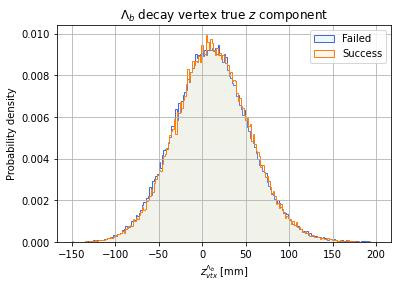

In [130]:
featureToPlot = 'MCTRUTH_Lb_ENDVERTEX_Z'
featureLabel = '$z^{\Lambda_b}_{vtx}$ [mm]'
featureTitle = '$\Lambda_b$ decay vertex true $z$ component'
binNumber = 200
boundaries = (-150,200)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

## $\Lambda$ decay vertices

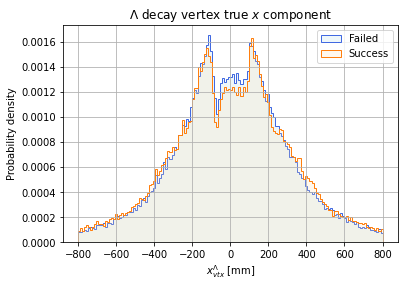

In [127]:
featureToPlot = 'MCTRUTH_L_ENDVERTEX_X'
featureLabel = '$x^{\Lambda}_{vtx}$ [mm]'
featureTitle = '$\Lambda$ decay vertex true $x$ component'
binNumber = 150
boundaries = (-800,800)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

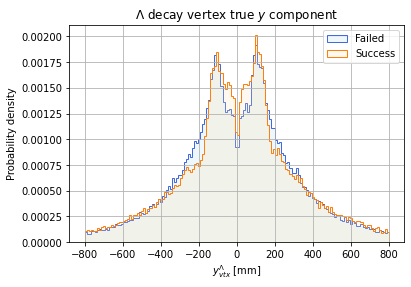

In [128]:
featureToPlot = 'MCTRUTH_L_ENDVERTEX_Y'
featureLabel = '$y^{\Lambda}_{vtx}$ [mm]'
featureTitle = '$\Lambda$ decay vertex true $y$ component'
binNumber = 150
boundaries = (-800,800)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

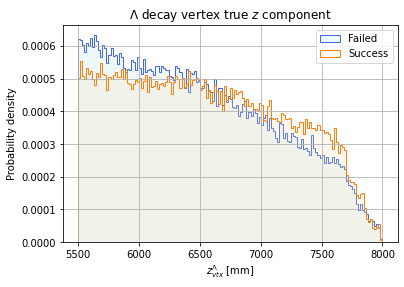

In [129]:
featureToPlot = 'MCTRUTH_L_ENDVERTEX_Z'
featureLabel = '$z^{\Lambda}_{vtx}$ [mm]'
featureTitle = '$\Lambda$ decay vertex true $z$ component'
binNumber = 150
boundaries = (5500,8000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()